# Авторы
Студенты группы M3439:

- Тепляков Валерий
- Плешаков Алексей
- Филипчик Андрей

# Source code
Исходный код можно посмотреть [тут](https://github.com/Mervap/OptimizationMethods/tree/master/lab2)

In [1]:
import math
import tracemalloc
from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt

from lab1.plot import plot_graph
from lab1.task1.golden_ratio import GoldenRatio
from lab1.task2.fastest_gradient_descent import FastestGradientDescent
from lab1.watcher import Watcher
from lab2.newton import Newton

# Задание 2

In [2]:
f1 = (
    r'$100(y - x)^2 + (1 - x)^2$',
    lambda x, y: 100 * (y - x) ** 2 + (1 - x) ** 2,       # function
    lambda x, y: [202 * x - 200 * y - 2, 200 * (y - x)],  # gradient
    lambda x, y: [[202, -200], [-200, 200]]               # hessian
)

f2 = (
    r'$100(y - x^2)^2 + (1 - x)^2$',
    lambda x, y: 100 * (y - x ** 2) ** 2 + (1 - x) ** 2,                          # function
    lambda x, y: [2 * (200 * x ** 3 - 200 * x * y + x - 1), 200 * (y - x ** 2)],  # gradient
    lambda x, y: [[1200 * x ** 2 - 400 * y + 2, -400 * x], [-400 * x, 200]],      # hessian
)

f3_exp_e1 = lambda x, y: math.exp(-(x - 2) ** 2 / 9 - (y - 3) ** 2 / 4)
f3_exp_e2 = lambda x, y: math.exp(-(x - 1) ** 2 / 4 - (y - 1) ** 2)

f3 = (
    r'$-(2e^{-(\frac{x - 1}{2})^2 - (y - 1)^2)} + 3e^{-(\frac{x - 2}{3})^2 - (\frac{y - 3}{2})^2})$',
    lambda x, y: (-2 * math.exp(-((x - 1) / 2) ** 2 - (y - 1) ** 2) +
                  -3 * math.exp(-((x - 2) / 3) ** 2 - ((y - 3) / 2) ** 2)),
    lambda x, y: [
        2 / 3 * (x - 2) * f3_exp_e1(x, y) + (x - 1) * f3_exp_e2(x, y),     # df/dx
        3 / 2 * (y - 3) * f3_exp_e1(x, y) + 4 * (y - 1) * f3_exp_e2(x, y), # df/dy
    ],
    lambda x, y: [
        [
            (-4 / 27 * (x - 2) ** 2 + 2 / 3) * f3_exp_e1(x, y) + (1 - 0.5 * (x - 1) ** 2) * f3_exp_e2(x, y), # df/dx^2
            -1 / 3 * (x - 2) * (y - 3) * f3_exp_e1(x, y) - 2 * (x - 1) * (y - 1) * f3_exp_e2(x, y),          # df/dxdy
        ],
        [
            -1 / 3 * (x - 2) * (y - 3) * f3_exp_e1(x, y) - 2 * (x - 1) * (y - 1) * f3_exp_e2(x, y),          # df/dydx
            (-3 / 4 * (y - 3) ** 2 + 3 / 2) * f3_exp_e1(x, y) + (4 - 8 * (y - 1) ** 2) * f3_exp_e2(x, y),    # df/dy^2
        ]
    ]
)

fs = [f1, f2, f3]

In [ ]:
initial_points = [
    np.array([0, 0]),
    np.array([-1, 2]),
    np.array([2, -1]),
    np.array([4.2, 2.4]),
    np.array([-0.01, 0.05]),
]

algs = [FastestGradientDescent, Newton]
opts = []
times = []
mems = []
mns = []
for (repr, f, grad, hessian) in fs:
    f = Watcher(f, grad, hessian)
    _opts = {alg: [] for alg in algs}
    _mns = { alg: [] for alg in algs }
    _times = []
    _mems = []
    for alg in algs:
        # Logs
        for ip in initial_points:
            try:
                opt = alg(f, 1e-6, GoldenRatio)
                mn = opt.opt(ip)
                _mns[alg].append(mn)
                _opts[alg].append(opt)
                print(mn, opt.get_iterations_cnt())
            except RuntimeError as e:
                if hasattr(e, 'message'):
                    print(e.message)
                else:
                    print(e)

        # Time/Memory
        tracemalloc.start()
        mn_time = 1e9
        for i in range(5):
            st = np.random.randn(2) * 1.5
            opt = alg(f, 1e-6, GoldenRatio, preserve_logs=False)
            try:
                start = datetime.now()
                opt.opt(st)
                elapsed_time = datetime.now() - start
                elapsed_micros = elapsed_time.seconds * 1e6 + elapsed_time.microseconds
                mn_time = min(mn_time, elapsed_micros)
            except RuntimeError as e:
                print(e)
                pass
        peek_mem = tracemalloc.get_traced_memory()[1] / 1024
        tracemalloc.stop()

        _times.append(mn_time / 1e3)
        _mems.append(peek_mem)
    opts.append(_opts)
    times.append(_times)
    mems.append(_mems)
    mns.append(_mns)

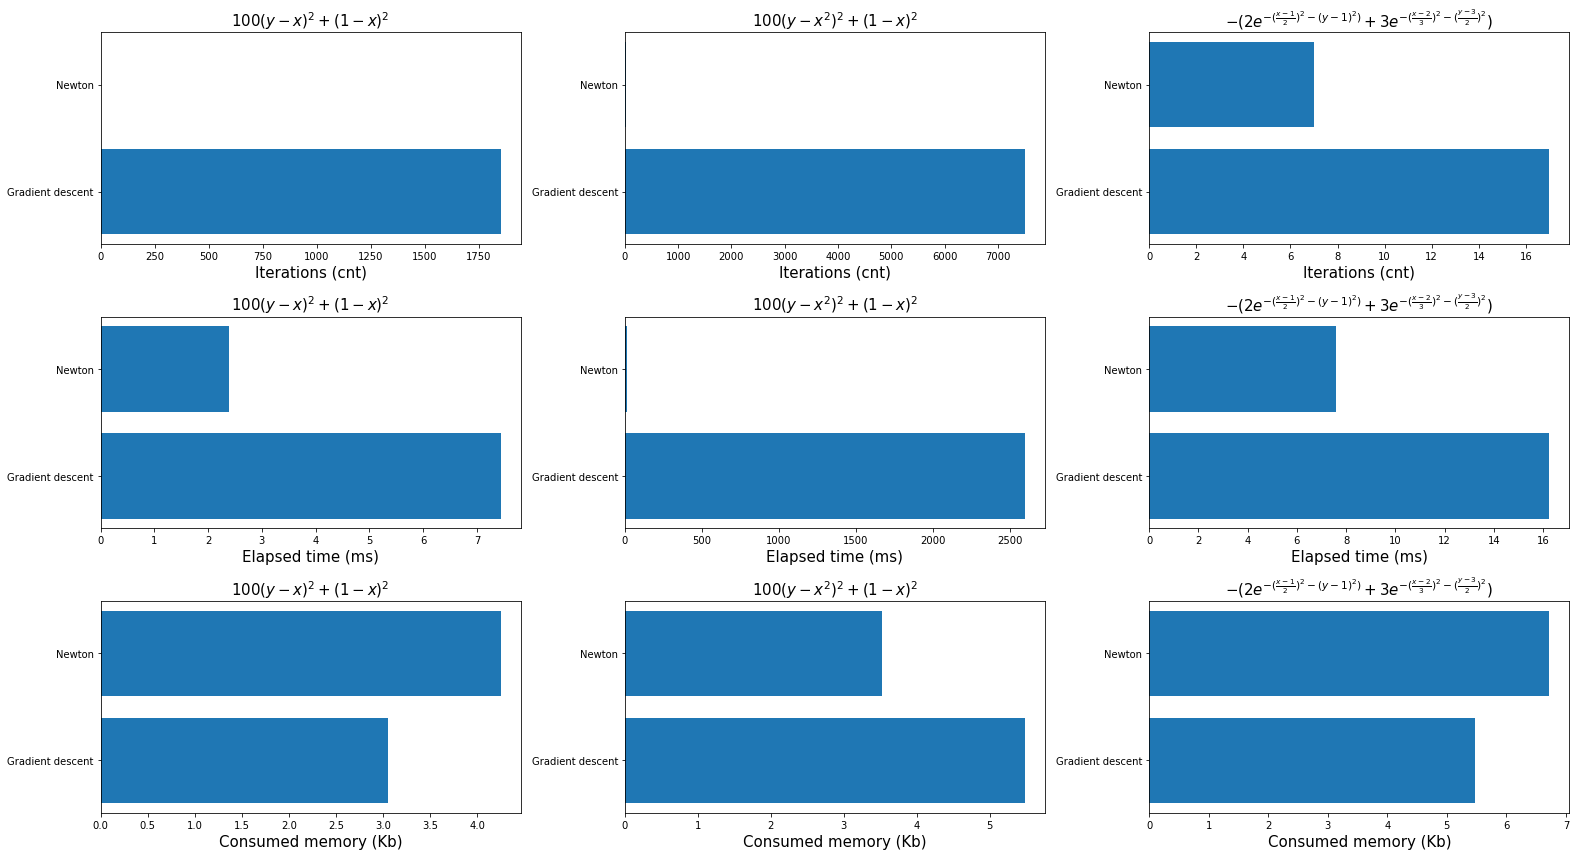

In [4]:
iter_stats = []
time_stats = []
mem_stats = []
for i in range(len(fs)):
    title = fs[i][0]
    _opts = opts[i]
    _times = times[i]
    _mems = mems[i]
    iter_stat = []
    time_stat = []
    mem_stat = []
    for j in range(len(algs)):
        alg = algs[j]
        worst_iter = max(map(lambda x: x.get_iterations_cnt(), _opts[alg]))
        iter_stat.append(worst_iter)
        time_stat.append(_times[j])
        mem_stat.append(_mems[j])
    iter_stats.append(("Iterations (cnt)", title, iter_stat))
    time_stats.append(("Elapsed time (ms)", title, time_stat))
    mem_stats.append(("Consumed memory (Kb)", title, mem_stat))

alg_names = list(map(lambda x: x.name, algs))
fig = plt.figure(figsize=(22, 12))
i = 0
for (x_label, title, stat) in iter_stats + time_stats + mem_stats:
    i += 1
    ax = fig.add_subplot(3, len(fs), i)
    ax.set_xlabel(x_label, fontsize=15)
    ax.set_title(title, fontsize=15)

    ax.barh(alg_names, stat, align='center')
    ax.set_yticks(np.arange(len(algs)))
    ax.set_yticklabels(alg_names)

fig.tight_layout()

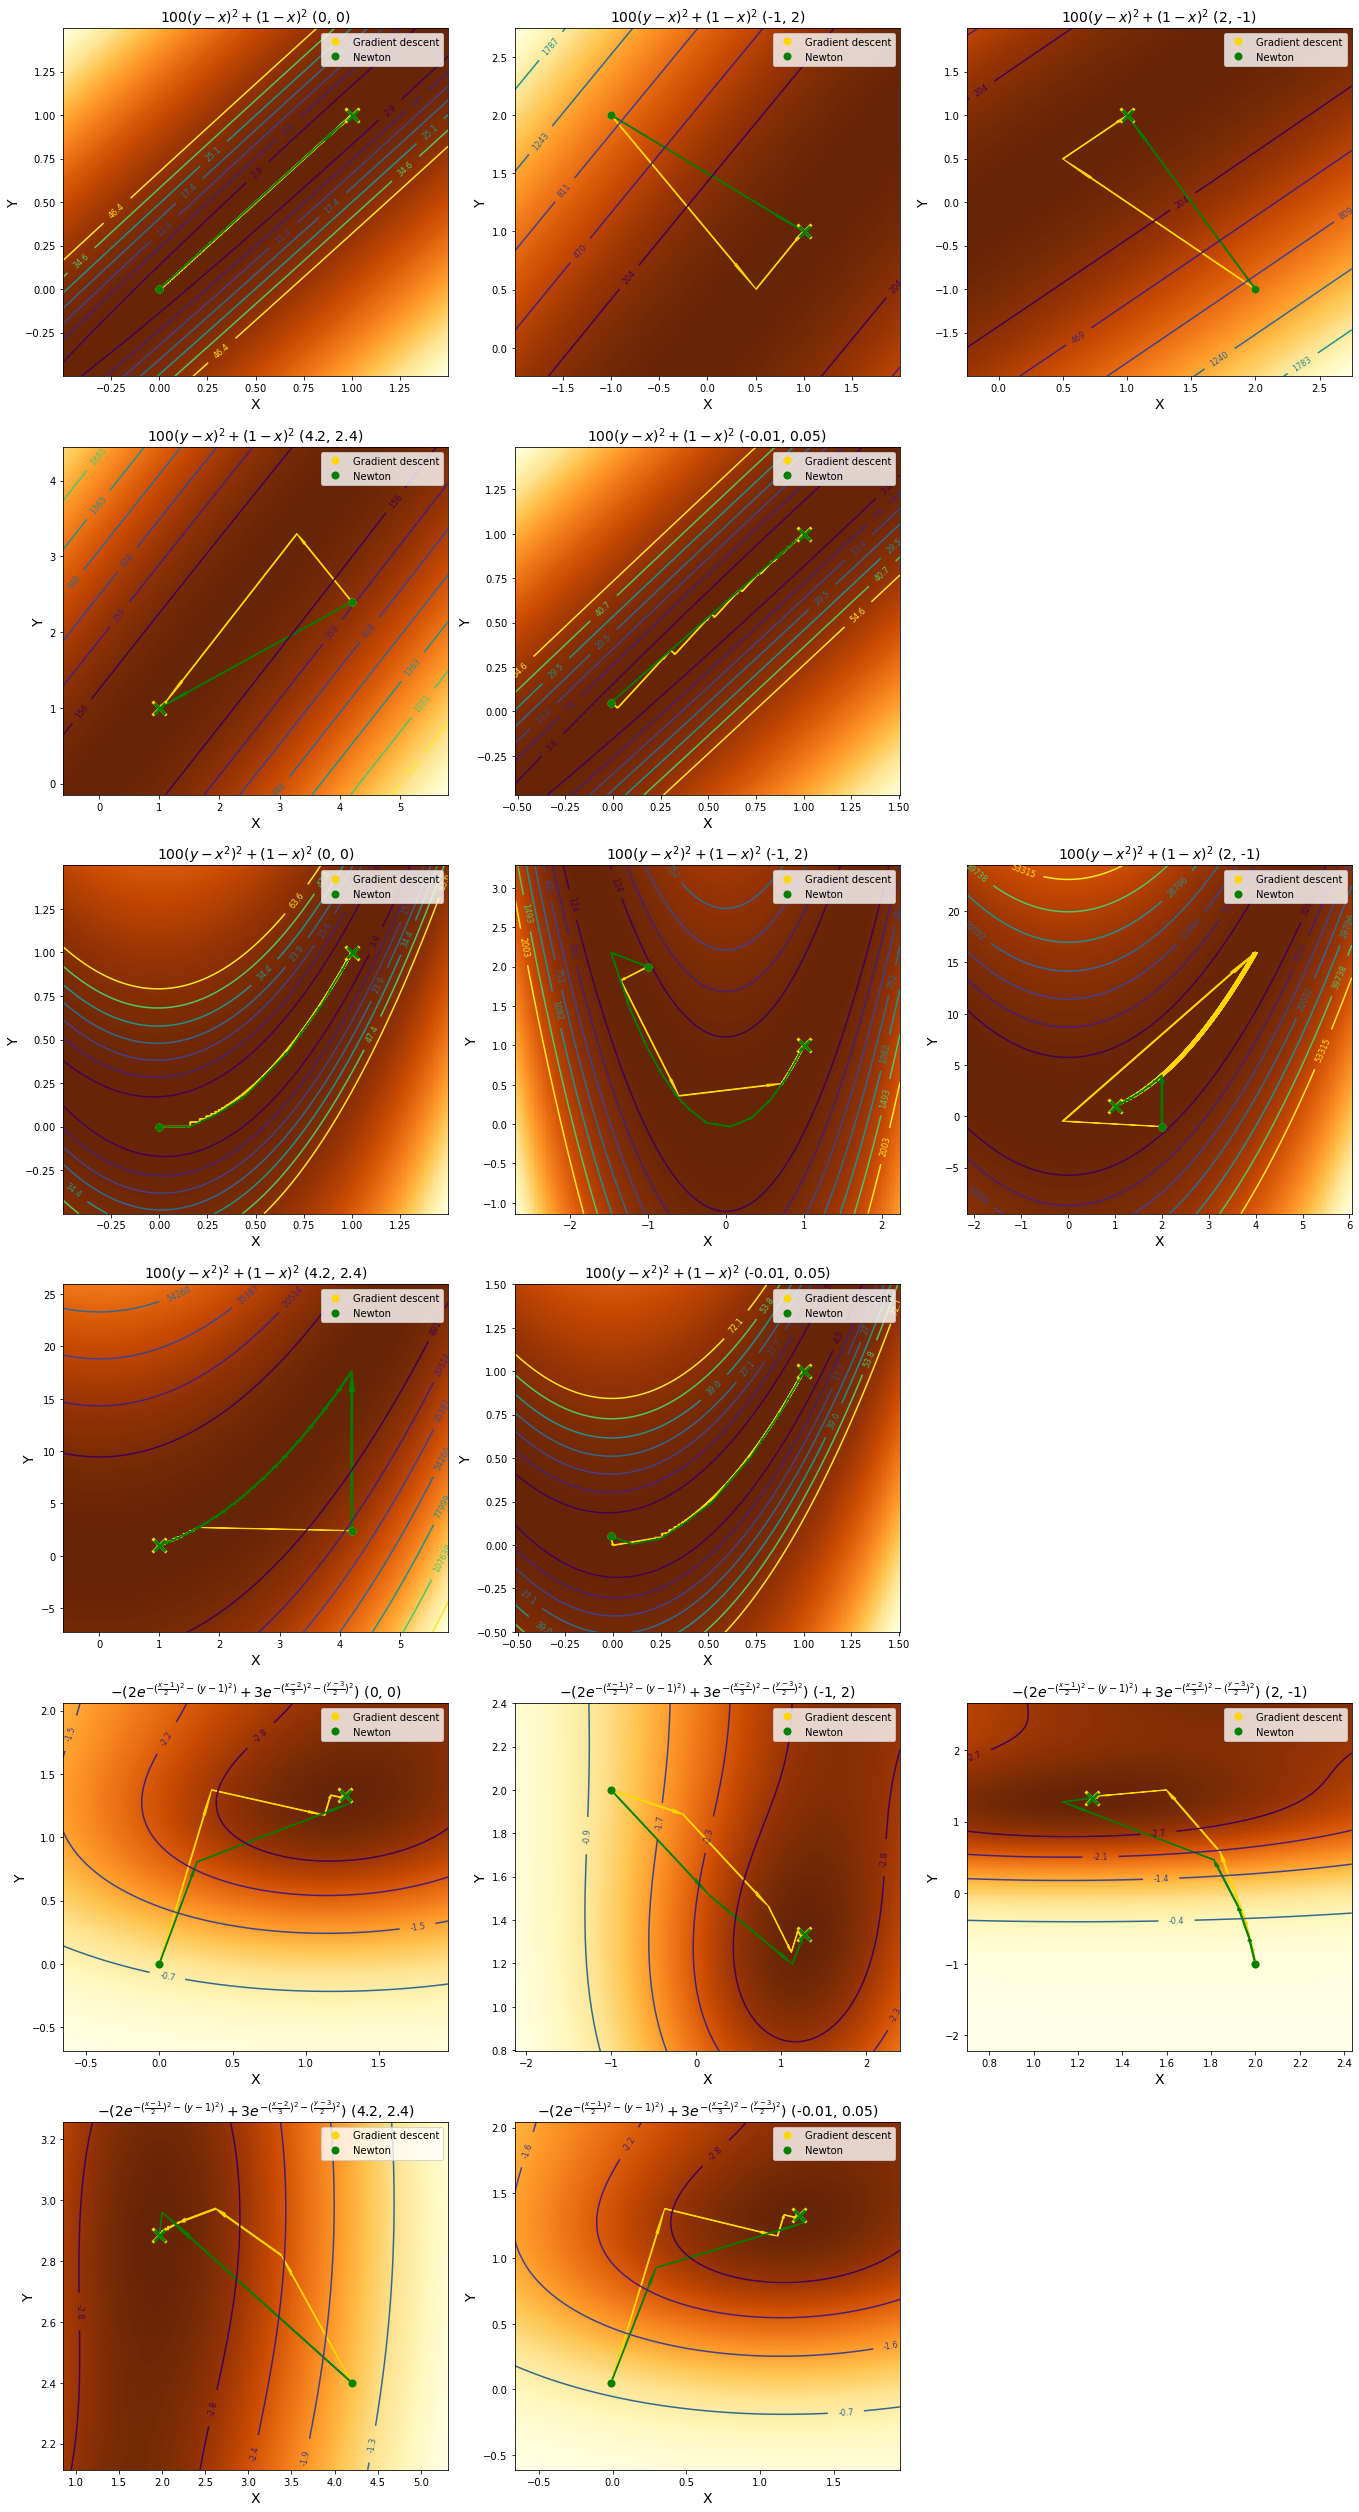

In [5]:
fig = plt.figure(figsize=(19, 35))
for j in range(len(fs)):
    for i in range(len(initial_points)):
        ip = initial_points[i]
        plot_graph(j * 6 + i + 1, fig,
                   [opts[j][alg][i] for alg in algs],
                   [ip for i in range(len(algs))],
                   [mns[j][alg][i] for alg in algs],
                   f'{fs[j][0]} ({ip[0]}, {ip[1]})', 100, 0, 0,
                   plt_size=(6, 3), labels=alg_names)
fig.tight_layout()